<a href="https://colab.research.google.com/github/daviddralle/salmonid_and_subsurface/blob/main/dry_season_lowflow_salmonid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and imports



In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
import glob
import pickle
import urllib
import datetime
import scipy
from scipy import stats
from scipy import stats
from pylab import *
from matplotlib.colors import ListedColormap
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import ee

!pip install -q geopandas
import geopandas as gp

     |████████████████████████████████| 1.1 MB 7.2 MB/s 
     |████████████████████████████████| 7.8 MB 32.2 MB/s 
     |████████████████████████████████| 16.6 MB 57 kB/s 


# Google Earth Engine required to pull rainfall data

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=axQU9QJQ-vHLzNowHBFtOZdP-vRumbcvTL4KtxspHys&tc=tQbsbI0PFJHjpUed6wD_sjrYZr5Dce9Z0UZpWlGoQFM&cc=lK1J_XZlFoGhD6xVsn57UQ96G2uEMHeCyPyl5Ta1uvM

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfgeXvubdQptFCwilEARR0bvandM2Upl0WDH1E5QTo8OGkKLixXArJIUNRw

Successfully saved authorization token.


In [ ]:
def getFlow(site,start,stop):
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start+'&end_date='+stop
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site', 'datetime', 'q', 'a']
    df.index = pd.to_datetime(df.datetime)
    basin = gp.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%site)
    area_mm2 = basin.to_crs('epsg:26910').geometry[0].area*1000**2
    df = 2.44657555e12*df[['q']]/area_mm2    
    df.q = df.q.astype(float, errors='ignore')
    df.columns = [site]
    return df, basin
    

# Grab PRISM rainfall 

In [ ]:
lat,lon = 39.719368, -123.610090
ft = ee.Feature(ee.Geometry.Point(lon,lat))
ft = ft.set('site','Elder')
start = '1999-01-01'
stop = '2022-01-01'
dataset = ee.ImageCollection("OREGONSTATE/PRISM/AN81m").filter(ee.Filter.date(start, stop))
ppt = dataset.select('ppt').toBands()
ft = ppt.reduceRegion(ee.Reducer.mean(), ft.geometry(), 4000)
vals = ft.getInfo()
dates = pd.to_datetime([item.split('_')[0] for item in list(vals)],format='%Y%m')
pptvals = [item for item in vals.values()]
rainfall = pd.DataFrame({'Elder':pptvals},index=dates).resample('M').sum()

# Download flow data

In [ ]:
gageid = '11475560'
rainfall.columns = ['ppt']
elder,basin = getFlow(gageid,'2000-01-01','2021-12-30')
elder['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in elder.index]
rainfall['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in rainfall.index]
elder = elder.loc['2000-10-01':'2021-12-30']
rainfall = rainfall.loc['2000-10-01':'2021-12-30']

# Plot annual recessions and rainfall totals

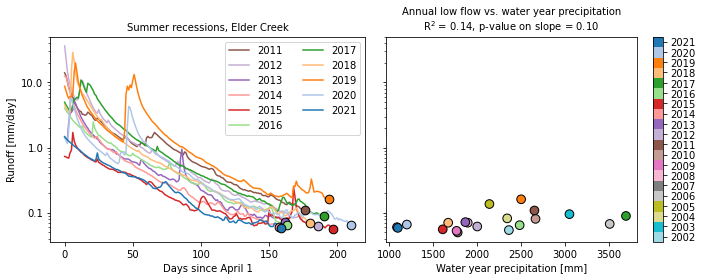

In [ ]:
years = (list(set(elder.index.year)))
years.sort()
wyrain = []
lowflow = []
yearplot = []
lowflowdate = []
for year in years[2:]:
    wystart = str(year-1) + '-10-01'
    wyend = str(year) + '-9-1'
    sd = str(year) + '-05-01'
    ed = str(year) + '-12-01'
    wyrain.append(rainfall.ppt.loc[wystart:wyend].sum())
    lowflow.append(elder['11475560'].loc[sd:ed].min())
    lowflowdate.append(elder['11475560'].loc[sd:ed].idxmin())
    yearplot.append(year)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(wyrain),np.array(lowflow))

f,axs = plt.subplots(1,2,figsize=(10,4), sharey=True)
cmap = ListedColormap(sns.color_palette('tab20',len(yearplot)).as_hex()).reversed()
pal = np.flip(sns.color_palette('tab20',len(yearplot)).as_hex(), axis=0)
ax = axs[1]
sp = ax.scatter(wyrain, lowflow,c=yearplot,cmap=cmap,s=75,edgecolors='k')
bounds = np.array([i for i in yearplot + [yearplot[-1]+1]])-0.5
plt.colorbar(sp, ticks=[i for i in yearplot if i%1==0], boundaries=bounds)
titlestr = 'Annual low flow vs. water year precipitation'
titlestr += '\nR$^2$ = %.2f, p-value on slope = %.2f'%(r_value**2, p_value)
ax.set_title(titlestr, fontsize=10)
ax.set_xlabel('Water year precipitation [mm]')
ax.set_yscale('log')
ax = axs[0]
tp = range(2011,2022)
labels = []
handles = []
for i,year in enumerate(years[2:]):
  if year in tp:
    sd = str(year) + '-4-01'
    ed = lowflowdate[i] 
    toplot = elder['11475560'].loc[sd:ed]
    x = range(len(toplot))
    h, = ax.plot(x,toplot,c=pal[i])
    handles.append(h)
    labels.append(year)        
    ax.scatter(x[-1],toplot[-1],c=pal[i],s=75,edgecolors='k',zorder=100)
  else:
    continue

ax.legend(labels, fontsize=10,ncol=2)
ax.set_ylabel('Runoff [mm/day]')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_title('Summer recessions, Elder Creek', fontsize=10)
ax.set_xlabel('Days since April 1')
f.tight_layout()
f.savefig('./lowflow_precip.pdf')